# Basic burn probability benchmarking
This script compares OCR burn probability data to historical U.S. fire perimeter data as a general, surface-level benchmark of the burn probabilities. The benchmark tests are adapted from [Moran et al. 2025](https://www.nature.com/articles/s41598-025-07968-6) (scientific reports), which applied similar methods to annually benchmark FSim-derived burn probability data from 2020-2023 in the state of California. 

We focus on the 2011 burn probability map (rather than the future 2047 case) and compare it to the full historical burn perimeter dataset. This approach implicitly assumes that the 2011 map does a reasonable job capturing historical burn probabilities. We're okay with this assumption because the only thing that makes the 2011 map relevant for the year 2011 is the land surface boundary conditions (not the specific weather of that year), which have been relatively stable across the historical record at the CONUS-scale. 

In [1]:
import os 

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns    # plotting
import xarray as xr

In [2]:
# --- set up processed data cases 
datpath = "s3://carbonplan-ocr/evaluation/benchmark-v0131/benchmarking-processed/"
slc = {
    "testbox": {},
    "CONUS": {'df1a_expandFactor_all': 8e6, 'df1a_expandFactor_NB': 6e6,
              'df1b_vmax_all': 0.001, 'df1b_vmax_NB': 0.001},
    "West of -98": {'df1a_expandFactor_all': 8e6, 'df1a_expandFactor_NB': 6e6,
              'df1b_vmax_all': 0.001, 'df1b_vmax_NB': 0.001},
    "East of -98": {'df1a_expandFactor_all': 8e6, 'df1a_expandFactor_NB': 8e6,
              'df1b_vmax_all': 0.001, 'df1b_vmax_NB': 0.001},
}

# ---------------------------------------------------------
# select the slice to plot 
slicename = "CONUS"
# ---------------------------------------------------------

# Bechmark 1a: BP of burned and non-burned pixels
Requires a lot of memory to do it the normal way. Instead, we lazily compute N bins and plot the resulting histogram bins in violin style (see `benchmarking_process_inputs.ipynb` for computation). We repeat it for all data and for just the "non-burnable" pixels of Riley et al.

In [3]:
# --- read in and process data 
df1a = pd.read_parquet(os.path.join(datpath, f"{slicename}_WTD_maskdf.parquet"))

# ( set bp range )
bp_range = (0, 0.14)  # max confirmed in `benchmarking_process_inputs.ipynb` with: bp.max(skipna=True).compute()

# compute median, mean, and cdf
def weighted_stats(bin_centers, weights):
    mean = np.sum(bin_centers * weights) / np.sum(weights)
    cdf = np.cumsum(weights) / np.sum(weights)
    median = np.interp(0.5, cdf, bin_centers)
    return mean, median, cdf

# [ ALL DATA ]
burned_mean, burned_median, burned_cdf = weighted_stats(df1a['bin_centers'], df1a['burned_BPdensity'])
unburned_mean, unburned_median, unburned_cdf = weighted_stats(df1a['bin_centers'], df1a['unburned_BPdensity'])
# [ UNBURNABLE ONLY ]
burned_mean_unburnable, burned_median_unburnable, burned_cdf_unburnable = weighted_stats(df1a['bin_centers'], df1a['burned_BPdensity_NB'])
unburned_mean_unburnable, unburned_median_unburnable, unburned_cdf_unburnable = weighted_stats(df1a['bin_centers'], df1a['unburned_BPdensity_NB'])

# replace zero density with nan (to avoid plotting zero density)
df1a['burned_BPdensity'] = df1a['burned_BPdensity'].replace(0, np.nan)
df1a['unburned_BPdensity'] = df1a['unburned_BPdensity'].replace(0, np.nan)
df1a['burned_BPdensity_NB'] = df1a['burned_BPdensity_NB'].replace(0, np.nan)
df1a['unburned_BPdensity_NB'] = df1a['unburned_BPdensity_NB'].replace(0, np.nan)


### Plot all data

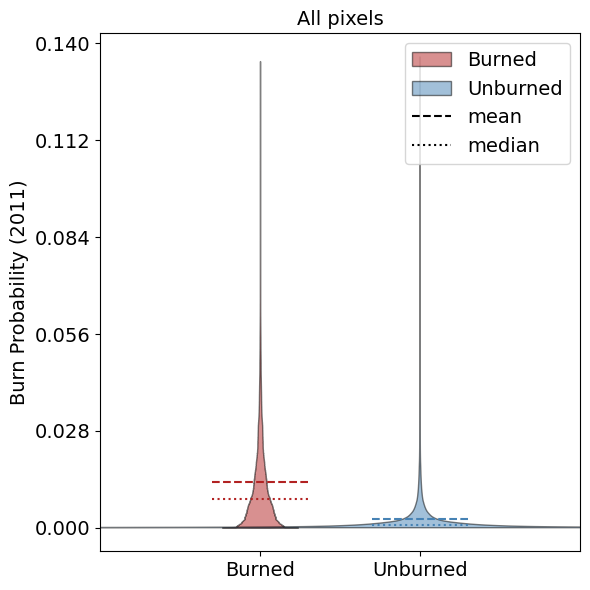

In [4]:
# [ ALL DATA ]
# --- aesthetics -------------
burncol = "firebrick"
unburncol = "steelblue"
edgecol = "black"
fill_alph = 0.5
lwd_mean = 1.5
lwd_median = 1.5
fs_title = 14
fs_tick = 14
fs_axtitle = 14
fs_leg = 14
ls_mean = "--"
ls_median = ":"
line_buff = 0.3
# ----------------------------

# plot 
fig, ax = plt.subplots(figsize=(6, 6))
width = (df1a['bin_centers'][1] - df1a['bin_centers'][0])*slc[slicename].get('df1a_expandFactor_all', 3e6)

# violin shapes
ax.fill_betweenx(df1a['bin_centers'], -df1a['burned_BPdensity'] * width, df1a['burned_BPdensity'] * width, edgecolor=edgecol,
                 facecolor=burncol, alpha=fill_alph, label="Burned")
ax.fill_betweenx(df1a['bin_centers'], 1 - df1a['unburned_BPdensity'] * width, 1 + df1a['unburned_BPdensity'] * width, edgecolor=edgecol,
                 facecolor=unburncol, alpha=fill_alph, label="Unburned")

# mean and median lines
ax.plot([-line_buff,line_buff], [burned_mean, burned_mean], color=burncol, 
        linestyle=ls_mean, linewidth=lwd_mean)
ax.plot([-line_buff,line_buff], [burned_median, burned_median], color=burncol, 
        linestyle=ls_median, linewidth=lwd_median)
ax.plot([-line_buff+1,line_buff+1], [unburned_mean, unburned_mean], color=unburncol, 
        linestyle=ls_mean, linewidth=lwd_mean)
ax.plot([-line_buff+1,line_buff+1], [unburned_median, unburned_median], color=unburncol, 
        linestyle=ls_median, linewidth=lwd_median)
# (lines for label only)
ax.plot([0,0], [0, 0], color='black', linestyle=ls_mean, linewidth=lwd_mean, label="mean")
ax.plot([0,0], [0, 0], color='black', linestyle=ls_median, linewidth=lwd_median, label="median")

# labels and formatting
ax.tick_params(axis='both', labelsize=fs_tick)
ax.set_yticks(np.linspace(bp_range[0], bp_range[1], 6))
ax.set_ylabel("Burn Probability (2011)", fontsize=fs_axtitle)
ax.set_xticks([0, 1])
ax.set_xticklabels(["Burned", "Unburned"])
ax.set_xlim(-1, 2)
ax.legend(fontsize=fs_leg, loc = "upper right")
plt.title("All pixels", fontsize=fs_title)
plt.tight_layout()

plt.show()
plt.close()

### Plot non-burnable data only

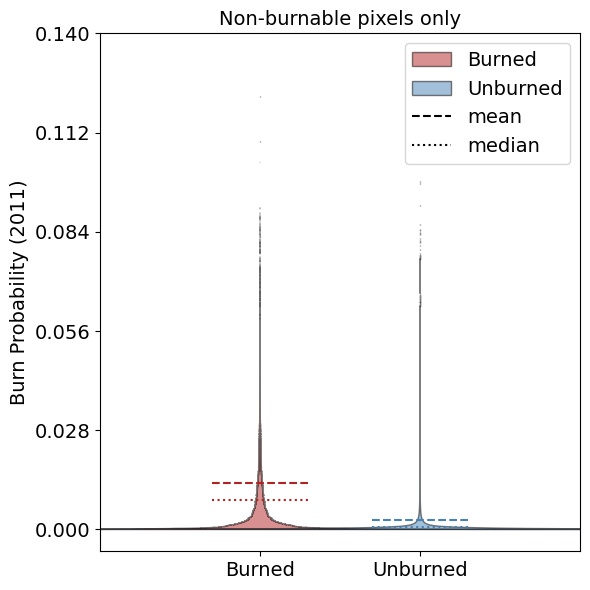

In [5]:
# [ NON-BURNABLE ONLY ]
# --- aesthetics -------------
burncol = "firebrick"
unburncol = "steelblue"
edgecol = "black"
fill_alph = 0.5
lwd_mean = 1.5
lwd_median = 1.5
fs_title = 14
fs_tick = 14
fs_axtitle = 14
fs_leg = 14
ls_mean = "--"
ls_median = ":"
line_buff = 0.3
# ----------------------------

# plot 
fig, ax = plt.subplots(figsize=(6, 6))
width = (df1a['bin_centers'][1] - df1a['bin_centers'][0])*slc[slicename].get('df1a_expandFactor_NB', 3e6)

# violin shapes
ax.fill_betweenx(df1a['bin_centers'], -df1a['burned_BPdensity_NB'] * width, df1a['burned_BPdensity_NB'] * width, edgecolor=edgecol,
                 facecolor=burncol, alpha=fill_alph, label="Burned")
ax.fill_betweenx(df1a['bin_centers'], 1 - df1a['unburned_BPdensity_NB'] * width, 1 + df1a['unburned_BPdensity_NB'] * width, edgecolor=edgecol,
                 facecolor=unburncol, alpha=fill_alph, label="Unburned")

# mean and median lines
ax.plot([-line_buff,line_buff], [burned_mean, burned_mean], color=burncol, 
        linestyle=ls_mean, linewidth=lwd_mean)
ax.plot([-line_buff,line_buff], [burned_median, burned_median], color=burncol, 
        linestyle=ls_median, linewidth=lwd_median)
ax.plot([-line_buff+1,line_buff+1], [unburned_mean, unburned_mean], color=unburncol, 
        linestyle=ls_mean, linewidth=lwd_mean)
ax.plot([-line_buff+1,line_buff+1], [unburned_median, unburned_median], color=unburncol, 
        linestyle=ls_median, linewidth=lwd_median)
# (lines for label only)
ax.plot([0,0], [0, 0], color='black', linestyle=ls_mean, linewidth=lwd_mean, label="mean")
ax.plot([0,0], [0, 0], color='black', linestyle=ls_median, linewidth=lwd_median, label="median")

# labels and formatting
ax.tick_params(axis='both', labelsize=fs_tick)
ax.set_yticks(np.linspace(bp_range[0], bp_range[1], 6))
ax.set_ylabel("Burn Probability (2011)", fontsize=fs_axtitle)
ax.set_xticks([0, 1])
ax.set_xticklabels(["Burned", "Unburned"])
ax.set_xlim(-1, 2)
ax.legend(fontsize=fs_leg, loc = "upper right")
plt.title("Non-burnable pixels only", fontsize=fs_title)
plt.tight_layout()

plt.show()
plt.close()

### Plot as CDFs

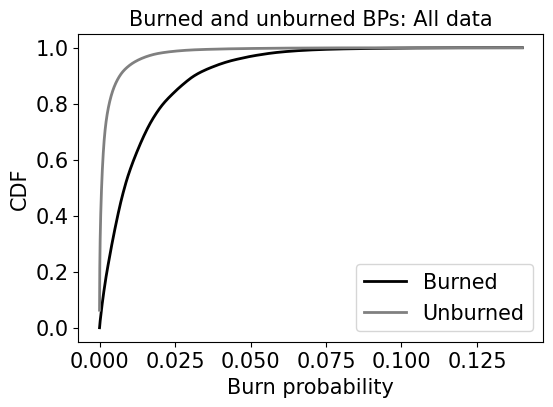

In [6]:
# [ ALL DATA ]
# ( use plotdata from above )
# --- PLOT 
# [ aesthetics ]
lsize = 2
burncol = 'black'
unburncol = 'gray'
pgrid = False
fsize=15
# -----------------

# Plot
plt.figure(figsize=(6,4))
plt.plot(df1a['bin_centers'], burned_cdf, label='Burned', linestyle='-', linewidth=lsize, color=burncol)
plt.plot(df1a['bin_centers'], unburned_cdf, label='Unburned', linestyle='-', linewidth=lsize, color=unburncol)
plt.xlabel("Burn probability", fontsize=fsize)
plt.ylabel("CDF", fontsize=fsize)
plt.title("Burned and unburned BPs: All data", fontsize=fsize)
plt.tick_params(axis='both', which='major', labelsize=fsize)
plt.grid(pgrid)
plt.legend(loc='lower right', fontsize=fsize)

plt.show()
plt.close()

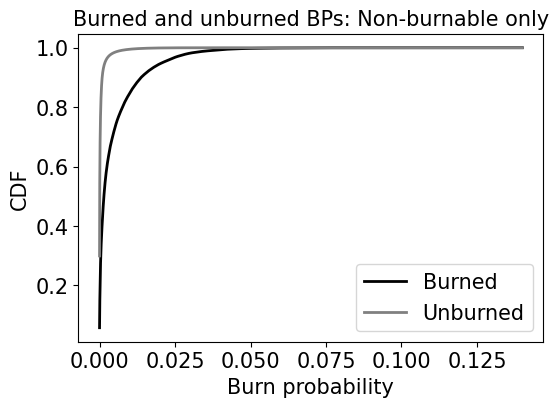

In [7]:
# [ NON-BURNABLE DATA ONLY ]
# ( use plotdata from above )
# --- PLOT 
# [ aesthetics ]
lsize = 2
burncol = 'black'
unburncol = 'gray'
pgrid = False
fsize=15
# -----------------

# Plot
plt.figure(figsize=(6,4))
plt.plot(df1a['bin_centers'], burned_cdf_unburnable, label='Burned', linestyle='-', linewidth=lsize, color=burncol)
plt.plot(df1a['bin_centers'], unburned_cdf_unburnable, label='Unburned', linestyle='-', linewidth=lsize, color=unburncol)
plt.xlabel("Burn probability", fontsize=fsize)
plt.ylabel("CDF", fontsize=fsize)
plt.title("Burned and unburned BPs: Non-burnable only", fontsize=fsize)
plt.tick_params(axis='both', which='major', labelsize=fsize)
plt.grid(pgrid)
plt.legend(loc='lower right', fontsize=fsize)

plt.show()
plt.close()

# Bechmark 1b: BP distributions by number of burn events
Repeating the above analysis, but instead of just "burned" and "unburned", we split data up based on the number of burn events from 0 to 20.

In [9]:
# --- read in and process data 
ds1b = xr.open_zarr(os.path.join(datpath, f"{slicename}_sumds.zarr"))

# --- get mean and median lines
# Compute mean bin location per n_burn
mean_bin_per_nburn = (
    (ds1b['burned_BPdensity'] * ds1b['bin'])
    .sum(dim='bin') / ds1b['burned_BPdensity'].sum(dim='bin')
)
mean_bin_per_nburn_NB = (
    (ds1b['burned_BPdensity_NB'] * ds1b['bin'])
    .sum(dim='bin') / ds1b['burned_BPdensity_NB'].sum(dim='bin')
)
# compute median bin location per n_burn
median_bin_per_nburn = []
median_bin_per_nburn_NB = []
def weighted_stats(bin_centers, weights):
    mean = np.sum(bin_centers * weights) / np.sum(weights)
    cdf = np.cumsum(weights) / np.sum(weights)
    median = np.interp(0.5, cdf, bin_centers)
    return mean, median, cdf

for n_burn in ds1b.n_burns.values:
    _, median, _ = weighted_stats(
        ds1b['bin'].values,
        ds1b['burned_BPdensity'].sel(n_burns=n_burn).values
    )
    median_bin_per_nburn.append(median)

for n_burn in ds1b.n_burns.values:
    _, median, _ = weighted_stats(
        ds1b['bin'].values,
        ds1b['burned_BPdensity_NB'].sel(n_burns=n_burn).values
    )
    median_bin_per_nburn_NB.append(median)

# get CDFs as pd.DataFrame
cdf_per_nburn_list = []
cdf_per_nburn_NB_list = []
for n_burn in ds1b.n_burns.values:
    _, _, cdf = weighted_stats(
        ds1b['bin'].values,
        ds1b['burned_BPdensity'].sel(n_burns=n_burn).values
    )
    
    tmpdf = pd.DataFrame({
        'n_burn': n_burn,               # scalar, broadcasted automatically
        'bin': ds1b['bin'].values,
        'CDF': cdf
    })
    cdf_per_nburn_list.append(tmpdf)
for n_burn in ds1b.n_burns.values:
    _, _, cdf = weighted_stats(
        ds1b['bin'].values,
        ds1b['burned_BPdensity_NB'].sel(n_burns=n_burn).values
    )
    
    tmpdf = pd.DataFrame({
        'n_burn': n_burn,               # scalar, broadcasted automatically
        'bin': ds1b['bin'].values,
        'CDF': cdf
    })
    cdf_per_nburn_NB_list.append(tmpdf)

cdf_df = pd.concat(cdf_per_nburn_list, ignore_index=True)
cdf_df_NB = pd.concat(cdf_per_nburn_NB_list, ignore_index=True)

Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0xfc25eafff750>
Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0xfc25eaf19730>, 923.346154907)])']
connector: <aiohttp.connector.TCPConnector object at 0xfc25eaffcf50>
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0xfc25eaffccd0>
Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0xfc25eaf19970>, 923.349156451)])']
connector: <aiohttp.connector.TCPConnector object at 0xfc25eaffc910>
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0xfc25eb8fb890>
Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0xfc25eaf19e50>, 923.355131675)])']
connector: <aiohttp.connector.TCPConnector object at 0xfc25eb864550>


GroupNotFoundError: No group found in store 's3://carbonplan-ocr/evaluation/benchmark-v090/benchmarking-processed/CONUS_sumds.zarr' at path ''

/Users/tylerkukla/Documents/GitHub/ocr/.pixi/envs/default/lib/python3.13/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


Text(0.5, 1.0, 'Burned BP density by number of burn events\nAll data')

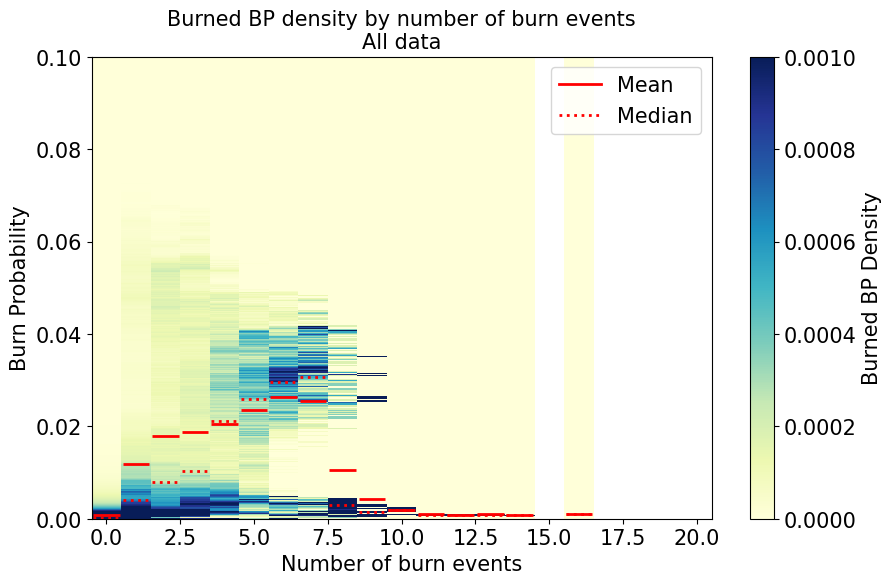

/Users/tylerkukla/Documents/GitHub/ocr/.pixi/envs/default/lib/python3.13/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


In [18]:
# [ ALL DATA ]
# --- PLOT 
# [ aesthetics ]
cmap='YlGnBu'
lsize = 2
meancol = 'red'
mediancol = 'red'
meanshape = 'solid'
medianshape = ':'
pgrid = False
fsize=15
# -----------------

# Plot the 2D density
plt.figure(figsize=(10, 6))
p = plt.pcolormesh(
    ds1b['n_burns'], 
    ds1b['bin'], 
    ds1b['burned_BPdensity'].T,  # transpose so axes match x=n_burns, y=bin
    shading='auto',
    cmap=cmap,
    vmin=0., vmax = slc[slicename].get('df1b_vmax_all', 0.001),
)
cbar = plt.colorbar(p)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label('Burned BP Density', fontsize=fsize)

# add mean and median lines
for n_burn, mean_y, med_y in zip(ds1b['n_burns'].values, mean_bin_per_nburn, median_bin_per_nburn):
    # Find approximate bin width in x (to size the segment nicely)
    if len(ds1b['n_burns']) > 1:
        dx = np.diff(ds1b['n_burns']).mean() * 0.45  # line spans 40% of the grid cell width
    else:
        dx = 0.4

    plt.hlines(mean_y, n_burn - dx, n_burn + dx, color=meancol, lw=lsize, linestyles=meanshape, label='_nolegend_')
    plt.hlines(med_y, n_burn - dx, n_burn + dx, color=mediancol, lw=lsize, linestyles=medianshape, label='_nolegend_')

# add legend entry for clarity
plt.plot([], [], meancol, lw=lsize, linestyle=meanshape, label='Mean')
plt.plot([], [], mediancol, lw=lsize, linestyle=medianshape, label='Median')
plt.legend(loc='upper right', fontsize=fsize)
plt.ylim(0, 0.1)

# add labels
plt.xlabel("Number of burn events", fontsize=fsize)
plt.ylabel("Burn Probability", fontsize=fsize)
plt.tick_params(axis='both', which='major', labelsize=fsize)
plt.title("Burned BP density by number of burn events\nAll data", fontsize=fsize)


Text(0.5, 1.0, 'Burned BP density by number of burn events\nNon-burnable data')

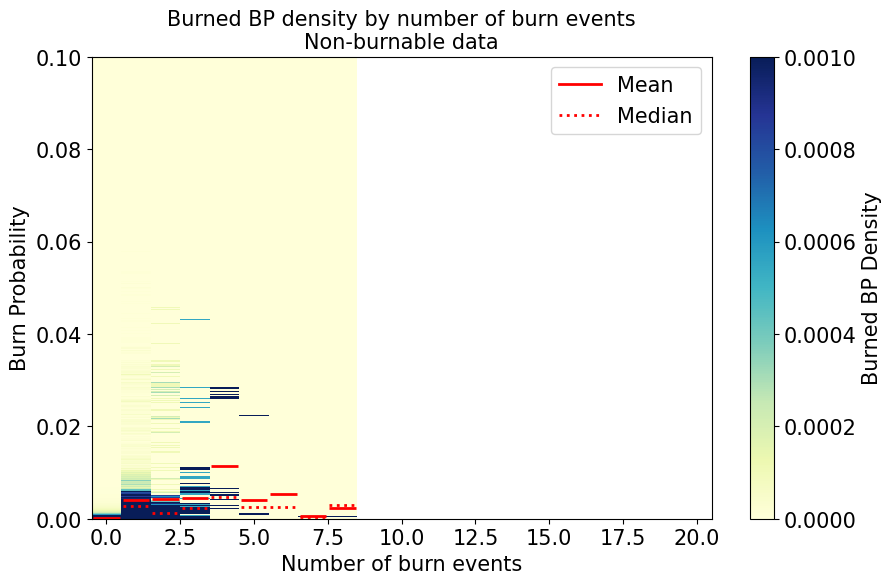

In [19]:
# [ NON-BURNABLE DATA ONLY ]
# --- PLOT 
# [ aesthetics ]
cmap='YlGnBu'
lsize = 2
meancol = 'red'
mediancol = 'red'
meanshape = 'solid'
medianshape = ':'
pgrid = False
fsize=15
# -----------------

# Plot the 2D density
plt.figure(figsize=(10, 6))
p = plt.pcolormesh(
    ds1b['n_burns'], 
    ds1b['bin'], 
    ds1b['burned_BPdensity_NB'].T,  # transpose so axes match x=n_burns, y=bin
    shading='auto',
    cmap=cmap,
    vmin=0., vmax = slc[slicename].get('df1b_vmax_NB', 0.001),
)
cbar = plt.colorbar(p)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label('Burned BP Density', fontsize=fsize)

# add mean and median lines
for n_burn, mean_y, med_y in zip(ds1b['n_burns'].values, mean_bin_per_nburn_NB, median_bin_per_nburn_NB):
    # Find approximate bin width in x (to size the segment nicely)
    if len(ds1b['n_burns']) > 1:
        dx = np.diff(ds1b['n_burns']).mean() * 0.45  # line spans 40% of the grid cell width
    else:
        dx = 0.4

    plt.hlines(mean_y, n_burn - dx, n_burn + dx, color=meancol, lw=lsize, linestyles=meanshape, label='_nolegend_')
    plt.hlines(med_y, n_burn - dx, n_burn + dx, color=mediancol, lw=lsize, linestyles=medianshape, label='_nolegend_')

# add legend entry for clarity
plt.plot([], [], meancol, lw=lsize, linestyle=meanshape, label='Mean')
plt.plot([], [], mediancol, lw=lsize, linestyle=medianshape, label='Median')
plt.legend(loc='upper right', fontsize=fsize)
plt.ylim(0, 0.1)

# add labels
plt.xlabel("Number of burn events", fontsize=fsize)
plt.ylabel("Burn Probability", fontsize=fsize)
plt.tick_params(axis='both', which='major', labelsize=fsize)
plt.title("Burned BP density by number of burn events\nNon-burnable data", fontsize=fsize)


### Plot as CDFs

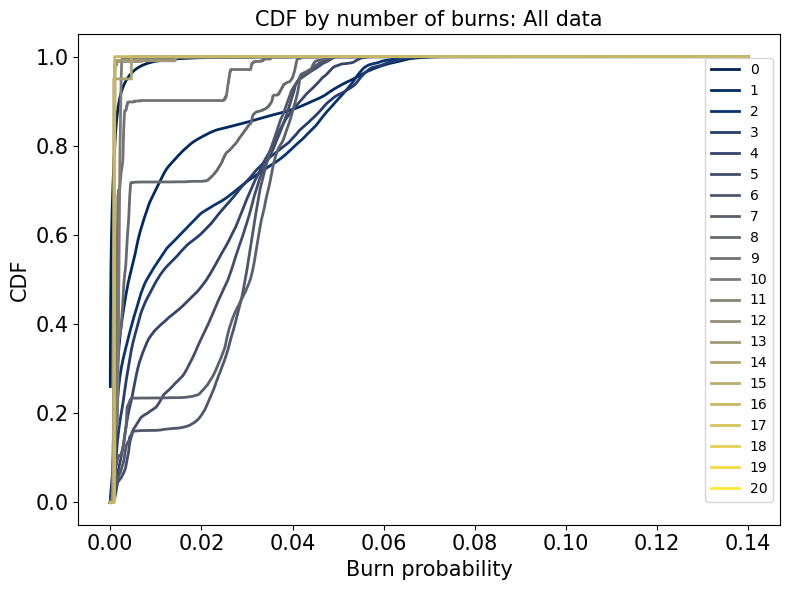

In [20]:
# [ ALL DATA ]
# ( use plotdata from above )
# --- PLOT 
# [ aesthetics ]
cmap = 'cividis'
lsize = 2
pgrid = False
fsize=15
# -----------------

plt.figure(figsize=(8,6))
sns.lineplot(
    data=cdf_df,
    x='bin',
    y='CDF',
    hue='n_burn',       # color by n_burn
    palette=cmap,  # or any other colormap
    legend='full',
    linewidth=lsize,
)

plt.xlabel("Burn probability", fontsize=fsize)
plt.ylabel("CDF", fontsize=fsize)
plt.tick_params(axis='both', which='major', labelsize=fsize)
plt.title("CDF by number of burns: All data", fontsize=fsize)
plt.tight_layout()
plt.legend(loc="right")

plt.show()
plt.close()

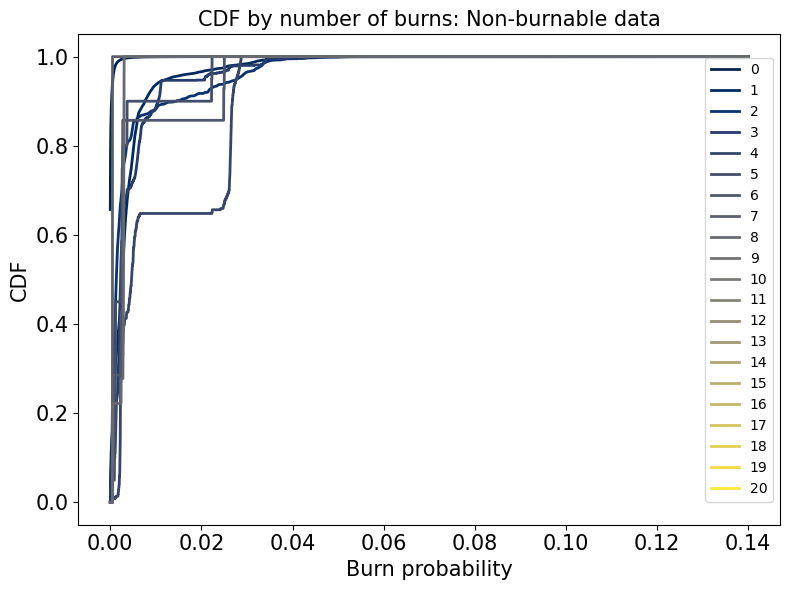

In [21]:
# [ NON-BURNABLE DATA ONLY ]
# ( use plotdata from above )
# --- PLOT 
# [ aesthetics ]
cmap = 'cividis'
lsize = 2
pgrid = False
fsize=15
# -----------------

plt.figure(figsize=(8,6))
sns.lineplot(
    data=cdf_df_NB,
    x='bin',
    y='CDF',
    hue='n_burn',       # color by n_burn
    palette=cmap,  # or any other colormap
    legend='full',
    linewidth=lsize,
)

plt.xlabel("Burn probability", fontsize=fsize)
plt.ylabel("CDF", fontsize=fsize)
plt.tick_params(axis='both', which='major', labelsize=fsize)
plt.title("CDF by number of burns: Non-burnable data", fontsize=fsize)
plt.tight_layout()
plt.legend(loc="right")

plt.show()
plt.close()

# Bechmark 2: Expected vs observed burn areas by burn class
We set 5 equal-area burn classes based on the burn probability data. Then we compute the expected and observed burn area for each class (product sum of burn probabilities and pixel areas) and compare the proportional area between the expected and observed data.

Expected burn area is computed by: $\text{expected annual burn area} = \sum_i(A_i\times BP_i)$

where $A$ is the area of pixel $i$ and $BP$ is its burn probability. 

Since all pixels have the same area, and since the ultimate calculation only cares about the relative proportions, we define each pixel's area as 1. This simplifies the equation to just the sum of burn probabilities, rather than the area-weighted sum-product.

In [26]:
# --- read in data
df2 = pd.read_parquet(os.path.join(datpath, f"{slicename}_burnclass_proportions.parquet"))
df2_nb =  pd.read_parquet(os.path.join(datpath, f"{slicename}_burnclass_proportions_NB.parquet"))

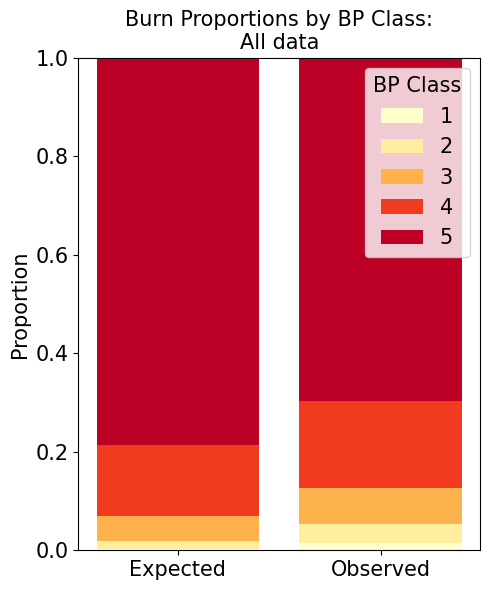

In [27]:
# [ ALL DATA ]
# --- PLOT
# [ aesthetics ]
colors = ['#ffffcc', '#ffeda0', '#feb24c', '#f03b20', '#bd0026']  
fsize = 15
# -----------------
series_list = [df2['bp2011_expected_burn_proportion'], df2['bp2011_observed_burn_proportion']]

# positions for the bars
x = np.arange(len(series_list))


fig, ax = plt.subplots(figsize=(5, 6))
# bottoms for stacking
for i, label in enumerate(df2['bp2011_expected_burn_proportion'].index):
    values = [s[label] for s in series_list]  # get this category for each series
    if i == 0:
        bottom = np.zeros(len(series_list))
    else:
        bottom = np.sum([s[0:label] for s in series_list], axis=1)
    ax.bar(x, values, bottom=bottom, color=colors[i], label=label)
    oldlabel = label

# Labels
ax.set_xticks(x)
ax.set_xticklabels(['Expected', 'Observed'])
ax.tick_params(labelsize=fsize)
ax.set_ylabel("Proportion", fontsize=fsize)
ax.set_ylim(0, 1)
ax.legend(title="BP Class", labels=df2['bp_class'].values, fontsize=fsize, title_fontsize=fsize)
ax.set_title("Burn Proportions by BP Class:\nAll data", fontsize=fsize)

plt.tight_layout()
plt.show()
plt.close()

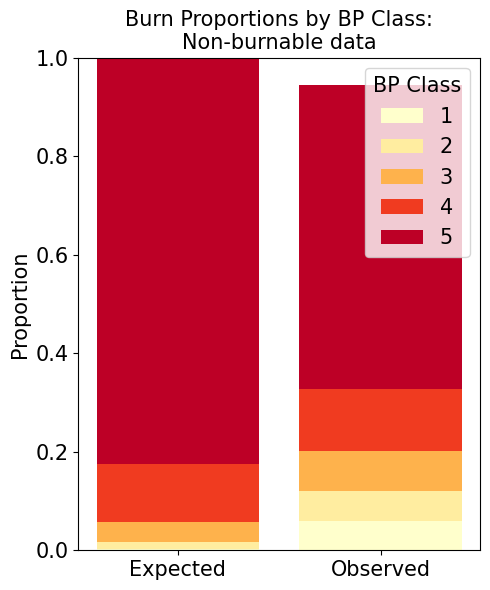

In [28]:
# [ NON-BURNABLE DATA ]
# --- PLOT
# [ aesthetics ]
colors = ['#ffffcc', '#ffeda0', '#feb24c', '#f03b20', '#bd0026']  
fsize = 15
# -----------------
series_list = [df2_nb['bp2011_expected_burn_proportion'], df2_nb['bp2011_observed_burn_proportion']]

# positions for the bars
x = np.arange(len(series_list))


fig, ax = plt.subplots(figsize=(5, 6))
# bottoms for stacking
for i, label in enumerate(df2_nb['bp2011_expected_burn_proportion'].index):
    values = [s[label] for s in series_list]  # get this category for each series
    if i == 0:
        bottom = np.zeros(len(series_list))
    else:
        bottom = np.sum([s[0:label] for s in series_list], axis=1)
    ax.bar(x, values, bottom=bottom, color=colors[i], label=label)
    oldlabel = label

# Labels
ax.set_xticks(x)
ax.set_xticklabels(['Expected', 'Observed'])
ax.tick_params(labelsize=fsize)
ax.set_ylabel("Proportion", fontsize=fsize)
ax.set_ylim(0, 1)
ax.legend(title="BP Class", labels=df2_nb['bp_class'].values, fontsize=fsize, title_fontsize=fsize)
ax.set_title("Burn Proportions by BP Class:\nNon-burnable data", fontsize=fsize)

plt.tight_layout()
plt.show()
plt.close()

# WIP: Logarithmic skill scores
### Compute the logarithmic score (LS) and logarithmic skill score (LSS)
Following Maron et al., 2025, the logarithmic score is defined by:

$\text{LS} = \frac{1}{N}\sum^{N}_{i-1} - \text{ln}\left(1-\left|p_i-o_i\right|\right)$

where $p_i$ is the burn probability of pixel $i$ and $o_i$ is the burn mask binary outcome (1 for burned, 0 for not burned).

We compute the $\text{LS}$ for the burn probability model as well as the two reference cases (random and uniform). THen we can compute the logarithmic skill score of the model relative to the reference cases by:

$\text{LSS} = 1 - \frac{\text{LS}}{\text{LS}_\text{ref}}$

where $\text{LS}_\text{ref}$ refers to either the random or uniform case logarithmic score.